# Application: Image Compression and Segmentation

```{contents}
```

Image compression is the process of reducing the size of an image file while maintaining its quality.

This is important because images take up a lot of memory and bandwidth, and therefore, compressing them can save time, space, and money.

A frequently used technique for image compression is vector quantization, which maps each pixel in an image to a more limited set of representative colors. One method to accomplish this is through K-Means clustering, where the image is divided into $K$ clusters and each pixel's color is replaced by the average color of its cluster. This results in the image being represented by $K$ distinct colors, which significantly reduces its size.

In [21]:
import sys
from pathlib import Path

parent_dir = str(Path().resolve().parents[3])
print(parent_dir)
sys.path.append(parent_dir)

from typing import Any, Dict, Tuple
from urllib.request import urlopen

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL
from rich.pretty import pprint
from skimage import color
from sklearn.cluster import KMeans
from tabulate import tabulate

from src.clustering.kmeans.kmeans import KMeansLloyd
from src.utils.plot import use_svg_display

use_svg_display()

/Users/gaohn/gao/gaohn-galaxy


In [22]:
root_dir = Path().resolve().parents[0]
assets_dir = root_dir / "assets"

## K-Means

Before we proceed, ensure that you have a grasp on what K-Means is and how it works. If you need a refresher, you can read the [K-Means concept](concept.md) page.

## Vector Quantization

Recall that we mentioned that vector quantization is a technique used in image compression to reduce the amount of data needed to represent an image, and that K-Means is a method of vector quantization. We shall see below that they are of equivalent form. Below is an adaptation from "Chapter 21.3. K-Means Clustering." In Probabilistic Machine Learning: An Introduction, written by Murphy, Kevin P.

Given a sequence of real-valued vector $\left\{\mathbf{x}^{(n)}\right\}_{n=1}^N$ where each $\mathbf{x}^{(n)} \in \mathbb{R}^{D}$, we can use vector quantization to perform a lossy compression as follows:

### Step 1.

First, we replace each real-valued vector $\mathbf{x}^{(n)} \in \mathbb{R}^D$ with a discrete symbol $\mathbf{z}^{(n)} \in \{1, \ldots , K\}$.

### Step 2. 

Then, we define a codebook of $K$ prototypes $\left\{\boldsymbol{\mu}_k\right\}_{k=1}^K \in \mathbb{R}^D$. Since each real-valued vector $\mathbf{x}^{(n)} \in \mathbb{R}^D$ is replaced with a discrete symbol $\mathbf{z}^{(n)} \in \{1, \ldots , K\}$, we can think of the codebook as a lookup table that maps each symbol to a prototype.

### Step 3.

Finally, we encode each real-valued vector $\mathbf{x}^{(n)} \in \mathbb{R}^D$ by identifying the prototype that is most similar to it, using Euclidean distance as a measure of similarity:

$$
\begin{equation} \text{encode}\left(\mathbf{x}^{(n)}\right) = \arg \min_{k} \left|\mathbf{x}^{(n)} - \boldsymbol{\mu}_k \right|^2 \end{equation}
$$

The quality of a codebook can be assessed by determining the reconstruction error or the amount of distortion it causes, as expressed by the following equation:

$$
\begin{equation} \mathcal{J} = \frac{1}{N} \sum_{n=1}^N |\mathbf{x}^{(n)} - \text{decode}\left(\text{encode}\left(\mathbf{x}^{(n)}\right)\right)|^2 = \frac{1}{N} \sum_{n=1}^N \left\|\mathbf{x}^{(n)} - \boldsymbol{\mu}_{\mathbf{z}^{(n)}}\right\|^2 \end{equation}
$$

where $\text{decode}(k) = \boldsymbol{\mu}_k$.

We see that the compression error has the same form as the K-Means cost function. And therefore we can use K-Means to perform vector quantization, and thereby achieving compression.

## A Primer on Binary Digits (Bits) and 8-bit Unsigned Integers

To better appreciate how image compression work, it is important to understand how images (and any information) are stored in computers.

Information is stored in computers as a series of bits, the smallest units of information used in a computer. They have binary values, meaning they can either be 0 or 1. A series of bits are used to represent data and constitute the backbone of all digital information.

Images are often stored in 8-bit precision, which means they are represented as 8-bit unsigned integers. An 8-bit unsigned integer is a type of integer data type that can store a positive value between 0 and 255, inclusive, without a sign bit. Each bit in an 8-bit unsigned integer requires one memory space and can only have a value of 0 or 1.

For example, let's say a pixel value is 100. It can be represented in 8-bit binary form as $01100100$. In an 8-bit unsigned integer representation, the most significant bit (leftmost bit) represents the value $2^{7}=128$, the second most significant bit represents $2^6=64$, the third most significant bit represents $2^5=32$, and all the way till the least significant bit (rightmost bit) represents $2^0=1$.

This is why most images range from 0 to 255, as they are stored as 8-bit unsigned integers.

The number of bits needed to store an image depends on the size of the image, the number of color channels, and the number of bits used to represent each color channel.

### Number of Bits needed for a Positive Integer

Given a positive integer $K$, the number of bits needed to represent it is:

$$
n_{bits} = \lceil \log_2 K \rceil
$$

where:

- $n_{bits}$ is the number of bits required;
- $\lceil \cdot \rceil$ is the ceiling function, which rounds up to the nearest integer.

```{prf:example} Example
:label: prf:example-bits

For example, if $K = 16$, then $n_{bits} = \lceil \log_2 16 \rceil = \lceil 4 \rceil = 4$.

More concretely, there are a total of $16$ numbers from $0$ to $15$, so the least number of bits required to represent these numbers is $4$.

- $0 \to 0000$
- $1 \to 0001$
- $10 \to 1010 = 1 \times 2^3 + 0 \times 2^2 + 1 \times 2^1 + 0 \times 2^0 = 8 + 2 = 10$
- $15 \to 1111$
  
Thus, with $4$ bits, you can represent $16$ different values ($0000, 0001, 0010, ..., 1111$), which is enough to represent the $16$ different numbers from $0$ to $15$.
```

With this formula, we can write a simple function that takes in a NumPy array and calculate the number of bits needed to store it. This function does not take into account negative numbers and many other things as it is only meant for educational purposes.

In [23]:
def calculate_num_bits(arr: np.ndarray, max_int: int) -> Tuple[int, int]:
    """
    Calculate the number of bits required to store a NumPy array.
    
    Parameters:
        arr (np.ndarray): A NumPy array.
        max_int (int): The maximum integer value allowed in this number system.
    
    Returns:
        num_bits (int): The number of bits required to store each value.
        total_bits (int): The number of bits required to store the array.
    """
    # number of bits required to store each value
    num_bits = int(math.ceil(math.log2(max_int))) 
    total_bits = num_bits * arr.size
    return num_bits, total_bits

In [24]:
calculate_num_bits(np.array([1, 2, 13, 16, 10]), 16)

(4, 20)

## Image Compression with K-Means

In image compression, we use K-Means to group similar pixels into $K$ clusters. Each cluster centroid represents a representative color for the pixels in the cluster, and we can map each pixel to the closest centroid. This reduces the number of colors required to represent the image, and thus the size of the image data. The mapping of each pixel to a cluster centroid can be stored using a smaller number of bits compared to the original 24-bit RGB values.

Where did this 24-bit come from? Let's define the problem statement and find out!

### Problem Statement

Let an image be denoted by $\mathbf{I} \in \mathbb{R}^{m \times n \times 3}$, where $m$ is the width of the image, $n$ is the height of the image, and 3 is the number of color channels representing the red, green, and blue colors.

We have the following properties:

- There are a total of $N = m \times n$ pixels in the image $\mathbf{I}$.
- Each pixel $\mathbf{x} = \begin{bmatrix} r & g & b \end{bmatrix}^T \in \mathbb{Z}_{rgb}^3$ on the image $\mathbf{I}$ is a 3-dimensional (3-D) tuple residing in the 3-D integer space comprising the intensities of the red, green and blue channels.
- $\mathbb{Z}_{rgb}$ represents all integers from $0$ to $255$. Therefore, each color channel in the pixel is of the range $0$ to $255$, and is assumed to be an 8-bit unsigned integer.

Based on our earlier discussion of bits, we require 8 bits to represent numbers from $0$ to $255$. It follows that each pixel contains $3 \times 8 = 24$ bits of information. Consequently, the total number of bits required to represent the image is $24 \times N = 24N$ bits.

Our aim is to find a compression map $h: \mathbb{R}^{N} \rightarrow \mathbb{R}^{M}$, where $M < N$, such that the number of bits required to represent the compressed image is less than the number of bits required to represent the original image.

The compressed output $\mathbf{z} = h(\mathbf{x})$ is therefore called a code (compressed representation) of the input $\mathbf{x}$ (original representation). 

We can then reconstruct the original image $\mathbf{I}$ from the compressed image $\mathbf{z}$ by a reconstruction map $r: \mathbb{R}^{M} \rightarrow \mathbb{R}^{N}$, such that $\hat{\mathbf{x}} = r(\mathbf{z}) = r(h(\mathbf{x}))$. Note that $\hat{\mathbf{x}}$ is the reconstructed representation of $\mathbf{x}$ and may or may not be the same as $\mathbf{x}$. If they are not the same, then the compression is lossy.

### Steps to Compress an Image

Here is a step-by-step guide of using K-Means for image compression, we will later
solidify this with code implementation.

- **Read the image**: Load the image $\mathbf{I}$ into memory. Typically $\mathbf{I}$ will be converted to a numpy array of shape $m \times n \times 3$.
- **Reshape the image data**: Reshape the image matrix $\mathbf{I}$ into a 2D array of size $N \times 3$, where $N = m \times n$ is the total number of pixels in the image. Each row of the array represents a pixel in the image. This step is necessary because K-Means expects a 2D array as input. One can now think of $N \times 3$ as a dataset $\mathcal{S}$ with $N$ data points, with $D=3$ features.
- **Apply K-Means clustering**: Apply K-Means clustering to the reshaped image data, using a user-defined number of clusters, $K$. This will group similar pixels into $K$ clusters and calculate the cluster centroids $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_K$. Each centroid is a 3-dimensional vector representing the RGB values of the representative color for the cluster.
- **Compress the image**: For each pixel in the image, find the closest cluster centroid $\boldsymbol{\mu}_k$ and replace the pixel with the index $\hat{y}^{(n)}$ of the centroid. 
- **Store the compressed image**: Store the compressed image, which includes the cluster centroids and the mapping of each pixel to a centroid, to disk.

### Example

To put things into perspective, let's consider a simple example.

```{prf:example} Example
:label: example-pixels

Let us consider an image of size $100 \times 100 \times 3$ pixels. 

Then there are $N = 100 \times 100 = 10,000$ pixels in the image, and each pixel is represented by a 3-dimensional vector.

Then assuming that each value in the RGB tuple is stored with 8 bits of precision, 
then the total number of bits required to represent the image is 

$$
24N = 24 \times 100 \times 100 = 240,000 \text{ bits}
$$ 

Then suppose we run K-Means with $K=16$ clusters. We will get $16$ cluster centroids, each of which is a $3$-dimensional vector.
This requires us to store $16 \times 3 = 48$ numbers, each of which is represented with 8 bits of precision. This leads
to a total of $16 \times 3 \times 8 = 384$ bits to store the cluster centroids.

Next we also need to store the mapping of each pixel in the image to a cluster centroid. This is an $N \times 1$ vector, 
and for each pixel, we are only storing a single number ranging from 0 to 15.
This means that we will need $\lceil \log_2 16 \rceil = 4$ bits to represent the index of the cluster centroid to which a pixel is assigned.
This amounts to a total of $10,000 \times 4 = 40,000$ bits to store the mapping of each pixel to a cluster centroid.

Thus, the total number of bits required to store the compressed image is

$$
40,000 + 384 = 40,384 \text{ bits}
$$

compared to the original image size of $240,000$ bits. This results in a compression ratio of 

$$
40,384 / 240,000 = 16.8\%
$$
```

### Step-By-Step Code Implementation

In this section, we will go through the process of applying K-Means for compressing images. Specifically, we will use a hestain[^reference-hestain] image, a type of tissue image stained with hematoxylin and eosin (H&E). Pathologists utilize this staining technique to differentiate between tissue types that are colored blue-purple and pink.

#### Load and Read the Image

Let's load the image into memory first.

In [25]:
image_path = "https://storage.googleapis.com/reighns/images/hestain.png"
image = np.array(PIL.Image.open(urlopen(image_path)).convert("RGB"))
image_shape = image.shape
print(f"Image shape: {image_shape}")
print(f"Image dtype: {image.dtype}") # to make sure it's uint8

Image shape: (227, 303, 3)
Image dtype: uint8


Here are the steps for the code:

- Define the image path as a URL, ```"https://storage.googleapis.com/reighns/images/hestain.png"```
- Convert the image into a numpy array using the ```PIL``` library, by opening the image using ```PIL.Image.open``` method and converting it into an RGB format using the ```convert``` method.
- Store the shape of the image as a tuple in the variable ```image_shape```.
- We print out the shape and data type of the image array.

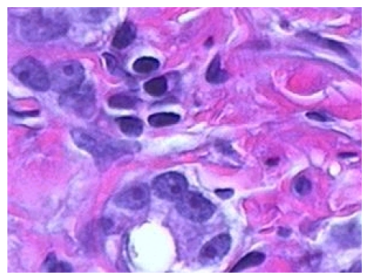

In [26]:
plt.axis("off")
plt.imshow(image);
plt.savefig(f"{assets_dir}/hestain.png", dpi=300)

#### Size of the Image

We use the function `calculate_num_bits` defined earlier to calculate how many bits this image takes.

In [27]:
_, image_size_in_bits = calculate_num_bits(image, 255)
print(f"Image size in bits: {image_size_in_bits}")

Image size in bits: 1650744


We can verify this number via the formula earlier: $227 \times 303 \times 24 = 1,650,744$.

### Applying Compression via K-Means

In what follows, we will write a function `compress_image` that takes in an image represented as a numpy array `image` and other optional parameters as a dictionary `kmeans_kwargs,` which are passed to the K-Means algorithm.

In [ ]:
def compress_image(
    image: np.ndarray, **kmeans_kwargs: Dict[str, Any]
) -> Tuple[np.ndarray, np.ndarray]:
    pixels = image.reshape((image.shape[0] * image.shape[1], 3))

    kmeans = KMeans(**kmeans_kwargs)
    kmeans.fit(pixels)

    compressed_image = kmeans.labels_.astype(np.uint8) # y_preds and convert to uint8
    centroids = kmeans.cluster_centers_ # total bits = 3 * 8 * K
    
    return compressed_image, centroids

The function performs the following steps:

- Reshapes the image from `(height, width, depth)` to `(height * width, depth)` to convert it into a 2D array, where each row is a pixel represented by its RGB values. We assign the reshaped image as a variable named `pixels`.
- Instantiate the K-Means algorithm with the given `kmeans_kwargs` and fit the K-Means model on the pixel data.
- Extract the predicted cluster labels for each pixel and name it `compressed_image`.
- Extract the predicted centroids (mean values) of each cluster and name it `centroids`.
- Return `compressed_image` and `centroids`. The former has the shape of `(N, 1)`, where `N` is the number of pixels in the image, and the latter has the shape of `(K, 3)`, where `K` is the number of clusters. Note that compressed_image is nothing but a 1D array of cluster labels and centroids is a 2D array of RGB values of the cluster centroids (the mean of each cluster).

Let's run the code with `K=2`.

In [29]:
K = 2
compressed_image, centroids = compress_image(
    image, n_clusters=K, n_init="auto", max_iter=300, random_state=42
)

print(centroids)

[[135.29518148  83.27374723 191.3692385 ]
 [205.86058271 141.38666637 238.61435827]]


The function `get_image_compression_ratio_for_kmeans` takes in four arguments:
- `image`: a NumPy array representing the original image
- `compressed_image`: a NumPy array representing the compressed imag obtained using the K-Means algorithm
- `centroids`: a NumPy array representing the centroids (mean values) o each cluster obtained using the K-Means algorithm
- $k$ `: an integer representing the number of clusters used for the K-Mean algorithm
- `display`: a boolean indicating whether to display the compression ratic or not. This parameter is optional and defaults to `True`.

The function then calculates the original size, compressed image size, and centroids size in bits by calling the `calculate_num_bits` function with the appropriate arguments. The `calculate_num_bits` function calculates the number of bits required to represent the input data based on the maximum value that can be stored for that data type. For example, for an image with pixel values ranging from 0 to 255 , each pixel value can be represented using 8 bits.

Next, the function calculates the total compressed size by adding the compressed image size and centroids size. The compression ratio is then calculated by dividing the compressed size by the original size.

If the `display` parameter is `True`, the function prints the table containing the original size, compressed size, and compression ratio.



In [30]:
# def get_image_compression_ratio(
#     image: np.ndarray, compressed_image: np.ndarray, centroids: np.ndarray
# ) -> float:
#     original_size = sys.getsizeof(image.tobytes()) * 8 # in bits
#     compressed_image_size = sys.getsizeof(compressed_image.tobytes()) * 8 # in bits
#     centroids_size = sys.getsizeof(centroids.tobytes()) * 8 # in bits
#     compressed_size = compressed_image_size + centroids_size
#     compression_ratio = original_size / compressed_size
#     print(f"Original size: {original_size}\nCompressed Image size: {compressed_image_size}\nCentroids size: {centroids_size}\nCompressed size: {compressed_size}\nCompression ratio: {compression_ratio}")
#     return compression_ratio

def get_image_compression_ratio_for_kmeans(
    image: np.ndarray, compressed_image: np.ndarray, centroids: np.ndarray, k: int, display:bool=True
) -> float:
    _, original_size = calculate_num_bits(image, 255)  # in bits
    _, compressed_image_size = calculate_num_bits(compressed_image, k)  # in bits
    _, centroids_size = calculate_num_bits(centroids, 255)  # in bits
    compressed_size = compressed_image_size + centroids_size
    compression_ratio = compressed_size / original_size
    
    if display:
        data = [
            ["Original size", original_size],
            ["Compressed Image size", compressed_image_size],
            ["Centroids size", centroids_size],
            ["Compressed size", compressed_size],
            ["Compression ratio", f"{compression_ratio:.2f}"]
        ]

        table = tabulate(data, headers=["Metric", "Value"], tablefmt="pretty")
        print(table)
    return compression_ratio

In [31]:
compressed_ratio = get_image_compression_ratio_for_kmeans(
    image, compressed_image, centroids, K
)

+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 1650744 |
| Compressed Image size |  68781  |
|    Centroids size     |   48    |
|    Compressed size    |  68829  |
|   Compression ratio   |  0.04   |
+-----------------------+---------+


### Reconstruction

In this section, we will write a function `reconstruct_image` that takes in the compressed image represented as a NumPy array `compressed_image`, the `centroids` that was learned from the K-Means algorithm, and `original_shape`, which is the shape of the original image.

In [32]:
def reconstruct_image(
    compressed_image: np.ndarray, centroids: np.ndarray, original_shape: Tuple[int, int, int]
) -> np.ndarray:
    reconstructed_image = centroids[compressed_image]
    reconstructed_image = reconstructed_image.reshape(original_shape).astype(np.uint8)
    return reconstructed_image

Let's see what the arguments represent:

- `compressed_image`: A NumPy array of shape `(N, 1)` representing the compressed image, where `N` is the number of pixels in the original image.
- `centroids`: A NumPy array of shape `(K, 3)` representing the cluster centroids obtained after performing K-Means on the original image.
- `original_shape`: A tuple representing the shape of the original image, in the format `(height, width, depth)`.

The function performs the following steps to reconstruct the original image from the compressed form:

1. It uses the `compressed_image` array to index into the `centroids` array, effectively replacing each pixel value in `compressed_image` with its corresponding cluster centroid.
2. It then reshapes the resulting array to match the original shape of the image.
3. Finally, it returns the reconstructed image as a NumPy array of unsigned 8-bit integers.
In summary, the reconstruct_image function takes a compressed image represented as a 1D array of cluster labels and the RGB values of the cluster centroids and returns the original image in its 3D NumPy array representation.

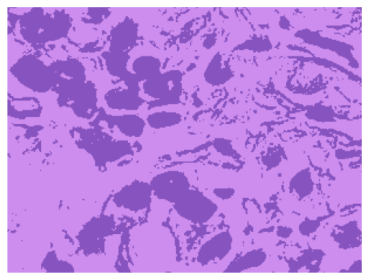

In [33]:
reconstructed_image = reconstruct_image(compressed_image, centroids, image.shape)

# fig = plt.figure(figsize=(8, 4))

plt.axis("off")
plt.imshow(reconstructed_image);
plt.savefig(f"{assets_dir}/reconstructed_image.png", dpi=300)

To make the colors more distinct, we can use `skimage.color`.

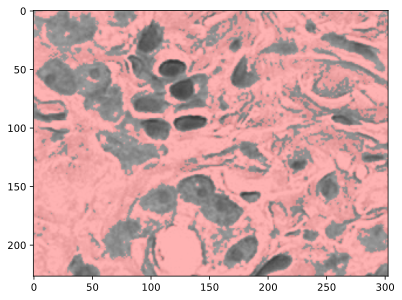

In [34]:
colored_image = color.label2rgb(compressed_image.reshape(image.shape[:2]), image)
plt.imshow(colored_image);

We can clearly see that with $K=2$ clusters, the image is dichotomized into two distinct segments. This is quite a coarse representation of the original image.

Let's run the compression technique a few more times, this time with $K=2, 3, 6$ and $16$ and observe the results.

+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 1650744 |
| Compressed Image size |  68781  |
|    Centroids size     |   48    |
|    Compressed size    |  68829  |
|   Compression ratio   |  0.04   |
+-----------------------+---------+
+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 1650744 |
| Compressed Image size | 137562  |
|    Centroids size     |   72    |
|    Compressed size    | 137634  |
|   Compression ratio   |  0.08   |
+-----------------------+---------+
+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 1650744 |
| Compressed Image size | 206343  |
|    Centroids size     |   144   |
|    Compressed size    | 206487  |
|   Compression ratio   |  0.13   |
+-----------------------+---------+
+-----------------------+---

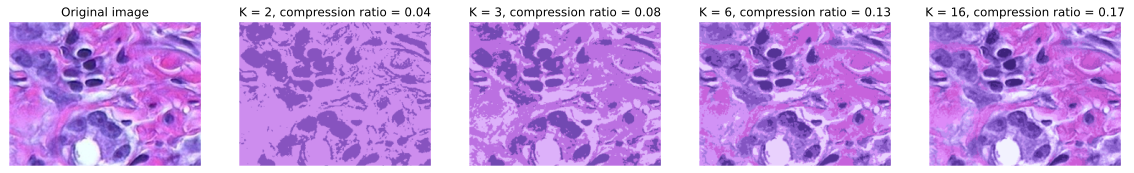

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True, sharey=True)

axes[0].imshow(image)
axes[0].set_title("Original image")
axes[0].axis("off")

# so centroids row 1 is the centroid for cluster 1
# etc
# and so for the original image, mask each pixel
# with the centroid's cluster, in other words
# each pixel becomes the centroid
for index, k in enumerate([2, 3, 6, 16], start=1):
    compressed_image, centroids = compress_image(image, n_clusters=k, n_init="auto", max_iter=300, random_state=42)
    compression_ratio = get_image_compression_ratio_for_kmeans(image, compressed_image, centroids, k)
    reconstructed_image = reconstruct_image(compressed_image, centroids, image.shape)
    axes[index].set_title(f"K = {k}, compression ratio = {compression_ratio:.2f}")
    axes[index].imshow(reconstructed_image)
    axes[index].axis("off")

fig.savefig(f"{assets_dir}/kmeans_compression.png", dpi=300)

As we can see, the quality of the compressed image will depend on the number of clusters used. In general, a larger number of clusters will result in higher image quality, but at the expense of a larger file size. 

We can also use our own implementation of K-Means to perform image compression, we see that the results are the same.
However, ours is very slow since not every operation is vectorized.

Using Seed Number 2023

Converged at iteration 23


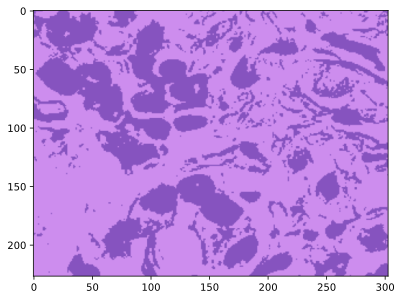

In [36]:
pixels = image.reshape((image.shape[0] * image.shape[1], 3))
kmeans = KMeansLloyd(num_clusters=2, init="random", max_iter=30, random_state=2023)

kmeans.fit(pixels)
y_preds = kmeans.labels
centroids = kmeans.centroids
# print(centroids)
segmented_image = centroids[y_preds]

segmented_image = segmented_image.reshape(image.shape) # reshape back

segmented_image = segmented_image.astype(np.uint8) # make int

plt.imshow(segmented_image)


In [37]:
image_path = "../assets/football.bmp"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 6130560 |
| Compressed Image size | 255440  |
|    Centroids size     |   48    |
|    Compressed size    | 255488  |
|   Compression ratio   |  0.04   |
+-----------------------+---------+
+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 6130560 |
| Compressed Image size | 510880  |
|    Centroids size     |   72    |
|    Compressed size    | 510952  |
|   Compression ratio   |  0.08   |
+-----------------------+---------+
+-----------------------+---------+
|        Metric         |  Value  |
+-----------------------+---------+
|     Original size     | 6130560 |
| Compressed Image size | 766320  |
|    Centroids size     |   144   |
|    Compressed size    | 766464  |
|   Compression ratio   |  0.13   |
+-----------------------+---------+


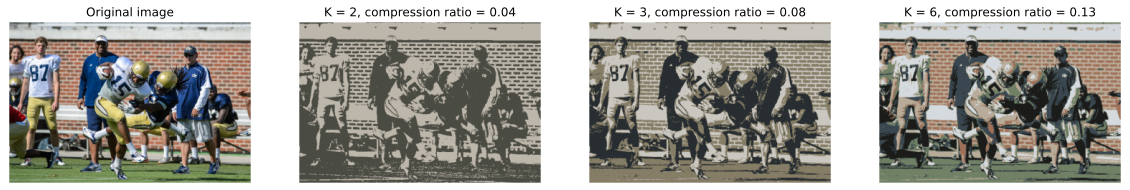

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 10), sharex=True, sharey=True)

axes[0].imshow(image)
axes[0].set_title("Original image")
axes[0].axis("off")

for index, k in enumerate([2, 3, 6], start=1):
    compressed_image, centroids = compress_image(image, n_clusters=k, n_init="auto", max_iter=300)
    compression_ratio = get_image_compression_ratio_for_kmeans(image, compressed_image, centroids, k)
    reconstructed_image = reconstruct_image(compressed_image, centroids, image.shape)
    axes[index].set_title(f"K = {k}, compression ratio = {compression_ratio:.2f}")
    axes[index].imshow(reconstructed_image)
    axes[index].axis("off")

It is important to note that while K-Means can provide significant size reductions for some images, it may not always be the best method for image compression. K-Means is a lossy compression method, meaning that the quality of the compressed image will be lower than the original image. This means that while it can provide significant size reductions, it may not always be the best method for image compression (i.e. if you are seeking for lossless compression).

The quality of the compressed image will depend on the number of clusters used and the similarity of the pixels in the image. In general, a larger number of clusters will result in higher image quality, but also a larger file size. Experimentation is often necessary to find the optimal number of clusters for a given image.

## Image Segmentation

Image compression using K-Means can be viewed as a form of image segmentation in the RGB space. Why is that the case? Let's first look at the definition of image segmentation.

> Image segmentation is the process of partitioning a digital image into multiple segments or regions, each of which corresponds to a separate object or part of the image. (Extracted from Wikipedia, Image Segmentation.)

Looking back at our K-Means algorithm, it divides the image into segments based on the similarities of the colors of the pixels in the image. In other words, this coincides with partitioning the image into $K$ colors, defined by each centroid. 

Consequently, this results in segmentation of the image via the color (RGB) space. 

One should however note that this method of segmentation **does not** take into account the spatial geometry of neighboring pixels, and thus result in a less meaningful representation of images. Let's see why.

Although K-Means does not assume any underlying probability distribution (unless you view it as Gaussian Mixture Model), we can still view the clustering method as treating each pixel as an independent data point and grouping them together solely based on their color values. As a result, neighboring pixels with different colors may be assigned to different clusters or segments, leading to a loss of spatial coherence in the resulting segmentation or compression. Therefore, if you think that segmenting an image based on the color space is not the aim, you might need to explore other methods. Modern deep learning tends to handle it better with more fine-grained segments.

## Conclusion

In this article, we covered how we can utilize K-Means as a way to compress images through the concept of vector quantization. We further link how the images can be segmented into different color spaces as a consequence of performing the clustering algorithm.

K-Means has many other applications, for example, in the context of Natural Language Processing (NLP), you can use it to [cluster documents](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html) as well.

## References and Further Readings

- Murphy, Kevin P. “Chapter 21.3. K-Means Clustering.” In Probabilistic Machine Learning: An Introduction. MIT Press, 2022.
- Bishop, Christopher M. "Chapter 9.1.1. Image Segmentation and Compression." In Pattern Recognition and Machine Learning. New York: Springer-Verlag, 2016.

[^codebook]: In the context of lossy compression, a codebook is a collection of prototypes, or a set of reference vectors, that are used to represent a set of real-valued vectors in a compressed form.
[^reference-hestain]: https://www.mathworks.com/help/images/color-based-segmentation-using-k-means-clustering.html